# SpaGCN implementation

follow the instruction: https://github.com/jianhuupenn/SpaGCN/blob/master/tutorial/tutorial.ipynb

In [ ]:

import anndata as ad
import SpaGCN as spg
import pandas as pd
import numpy as np
import scanpy as sc
import random
import torch
import os
import igraph

In [2]:
from SpaGCN import simple_GC_DEC
class SpaGCN_embed(spg.SpaGCN):
    def __init__(self):
        super(SpaGCN_embed, self).__init__()
        self.l=None

    def train(self,adata,adj,embed,
        num_pcs=50, 
        lr=0.005,
        max_epochs=2000,
        weight_decay=0,
        opt="admin",
        init_spa=True,
        init="louvain", #louvain or kmeans
        n_neighbors=10, #for louvain
        n_clusters=None, #for kmeans
        res=0.4, #for louvain
        tol=1e-3):
        self.num_pcs=num_pcs
        self.res=res
        self.lr=lr
        self.max_epochs=max_epochs
        self.weight_decay=weight_decay
        self.opt=opt
        self.init_spa=init_spa
        self.init=init
        self.n_neighbors=n_neighbors
        self.n_clusters=n_clusters
        self.res=res
        self.tol=tol
        assert adata.shape[0]==adj.shape[0]==adj.shape[1]

        # embed = embed[:,0:num_pcs]

        ###------------------------------------------###
        if self.l is None:
            raise ValueError('l should not be set before fitting the model!')
        adj_exp=np.exp(-1*(adj**2)/(2*(self.l**2)))
        #----------Train model----------
        adj_exp = np.ascontiguousarray(adj_exp)
        embed = np.ascontiguousarray(embed)
        
        self.model=simple_GC_DEC(embed.shape[1],embed.shape[1])
        self.model.fit(embed,adj_exp,lr=self.lr,max_epochs=self.max_epochs,weight_decay=self.weight_decay,opt=self.opt,init_spa=self.init_spa,init=self.init,n_neighbors=self.n_neighbors,n_clusters=self.n_clusters,res=self.res, tol=self.tol)
        self.embed=embed
        self.adj_exp=adj_exp

In [26]:
def search_res(adata, adj, l, target_num,use_rep, start=0.4, step=0.1, tol=5e-3, lr=0.05, max_epochs=10, r_seed=100, t_seed=100, n_seed=100, max_run=10):
    
    random.seed(r_seed)
    torch.manual_seed(t_seed)
    np.random.seed(n_seed)
    res=start
    print("Start at res = ", res, "step = ", step)
    clf=SpaGCN_embed()
    clf.set_l(l)
    clf.train(adata,adj,adata.obsm[use_rep],init_spa=True,res=res, tol=tol, lr=lr, max_epochs=max_epochs,n_clusters=target_num)
    y_pred, _=clf.predict()
    old_num=len(set(y_pred))
    print("Res = ", res, "Num of clusters = ", old_num)
    run=0
    while old_num!=target_num:
        random.seed(r_seed)
        torch.manual_seed(t_seed)
        np.random.seed(n_seed)
        old_sign=1 if (old_num<target_num) else -1
        clf=SpaGCN_embed()
        clf.set_l(l)
        clf.train(adata,adj,adata.obsm[use_rep],init_spa=True,res=res+step*old_sign, tol=tol, lr=lr, max_epochs=max_epochs,n_clusters=target_num)
        y_pred, _=clf.predict()
        new_num=len(set(y_pred))
        print("Res = ", res+step*old_sign, "Num of clusters = ", new_num)
        if new_num==target_num:
            res=res+step*old_sign
            print("recommended res = ", str(res))
            return res
        new_sign=1 if (new_num<target_num) else -1
        if new_sign==old_sign:
            res=res+step*old_sign
            print("Res changed to", res)
            old_num=new_num
        else:
            step=step/2
            print("Step changed to", step)
        if run >max_run:
            print("Exact resolution not found")
            print("Recommended res = ", str(res))
            return res
        run+=1
    print("recommended res = ", str(res))
    return res

def run_SpaGCN_embed(adata,use_rep, p = 0.5, n_clusters = None):

    r_seed = t_seed = n_seed = 0
    random.seed(r_seed)
    torch.manual_seed(t_seed)
    np.random.seed(n_seed)
    
    # calculate adjacency matrix
    print('# calculate adjacency matrix')
    x_array = adata.obsm["spatial"][:,0].tolist()
    y_array = adata.obsm["spatial"][:,1].tolist()
    adj = spg.calculate_adj_matrix(x = x_array, y = y_array, histology = False)

    # set hyper-parameters
    print('# set hyper-parameters')
    l = spg.search_l(p, adj, start = 0.01, end = 1000, tol = 0.01, max_run = 100)
    # n_clusters = adata.obs['ground_truth'].unique().size
    n_clusters = adata.obs['ground_truth'].unique().size if n_clusters is None else n_clusters

    res = search_res(
        adata, adj, l, n_clusters, use_rep=use_rep,
        start = 0.7, step = 0.1, 
        tol = 5e-3, lr = 0.05, 
        max_epochs = 20, r_seed = r_seed, t_seed = t_seed, n_seed = n_seed)

    # run spaGCN
    print('# run spaGCN')
    clf = SpaGCN_embed()
    clf.set_l(l)

    clf.train(adata, adj, adata.obsm[use_rep] ,init_spa = True, res = res, tol = 5e-3, lr = 0.05, max_epochs = 200,n_clusters=n_clusters)
    y_pred, prob = clf.predict()
    adata.obs["pred"]= y_pred
    adata.obs["pred"] = adata.obs["pred"].astype('category')

    # cluster refinement
    print('# cluster refinement')
    adj_2d = spg.calculate_adj_matrix(x = x_array, y = y_array, histology = False)
    refined_pred = spg.refine(sample_id = adata.obs.index.tolist(), pred = adata.obs["pred"].tolist(), dis = adj_2d, shape = "hexagon")

    return refined_pred

def run_SpaGCN_base(adata, p = 0.5, n_clusters = None):
    r_seed = t_seed = n_seed = 0
    random.seed(r_seed)
    torch.manual_seed(t_seed)
    np.random.seed(n_seed)
    
    # calculate adjacency matrix
    print('# calculate adjacency matrix')
    x_array = adata.obsm["spatial"][:,0].tolist()
    y_array = adata.obsm["spatial"][:,1].tolist()
    adj = spg.calculate_adj_matrix(x = x_array, y = y_array, histology = False)

    sc.pp.normalize_per_cell(adata)
    sc.pp.log1p(adata)
    # sc.pp.pca(adata)
    
    # set hyper-parameters
    print('# set hyper-parameters')
    l = spg.search_l(p, adj, start = 0.01, end = 1000, tol = 0.01, max_run = 100)
    n_clusters = adata.obs['ground_truth'].unique().size if n_clusters is None else n_clusters
    res = spg.search_res(
        adata, adj, l, n_clusters, #use_rep='X_pca',
        start = 0.7, step = 0.1, 
        tol = 5e-3, lr = 0.05, 
        max_epochs = 20, r_seed = r_seed, t_seed = t_seed, n_seed = n_seed)

    # run spaGCN
    print('# run spaGCN')
    clf = spg.SpaGCN()
    clf.set_l(l)

    clf.train(adata, adj ,init_spa = True, res = res, tol = 5e-3, lr = 0.05, max_epochs = 200,n_clusters=n_clusters,)
    y_pred, prob = clf.predict()
    adata.obs["pred"]= y_pred
    adata.obs["pred"] = adata.obs["pred"].astype('category')

    # cluster refinement
    print('# cluster refinement')
    adj_2d = spg.calculate_adj_matrix(x = x_array, y = y_array, histology = False)
    refined_pred = spg.refine(sample_id = adata.obs.index.tolist(), pred = adata.obs["pred"].tolist(), dis = adj_2d, shape = "hexagon")

    return refined_pred

## Running benchmark

In [ ]:
data_dir = './recode/IMPUTEDLIBD/processed/'
data_ids = [i for i in os.listdir(data_dir) if i.endswith('.h5ad')]
recoder = pd.DataFrame(columns = ['data','ari','ami','pre_type','clust_method'])

from sklearn.metrics import adjusted_rand_score as ari
from sklearn.metrics import adjusted_mutual_info_score as ami
from tqdm import tqdm

for data_id in tqdm(data_ids):

    adata = sc.read_h5ad(os.path.join(data_dir,data_id))
    ground = adata.obs['ground_truth']
    
    labels_base = run_SpaGCN_base(adata)
    recoder.loc[len(recoder),:] = data_id,ari(ground,labels_base),ami(ground,labels_base),'raw','SpaGCN'

    for use_rep in [
        'cell_ranger.pca',
        'p.spanve-k.imputated.pca', 'p.spanve-k.pca', #'spanve-k.imputated.pca', 'spanve-k.pca'
    ]:
        labels = run_SpaGCN_embed(adata, use_rep=use_rep)
        recoder.loc[len(recoder),:] = data_id,ari(ground,labels),ami(ground,labels),use_rep,'SpaGCN'


In [22]:
recoder.to_csv('./recode/IMPUTEDLIBD/SG.LV.res.csv', index=False)

## Breast cancer sample

In [ ]:
adata = sc.read_h5ad('./data/Human_breas_cancer.h5ad')
adata.X = adata.layers['counts'].copy()
adata.obsm['spanve_pca'] = sc.pp.pca(adata[:,adata.var.query('spanve_spatial_features').index].layers['normalized'])
label = run_SpaGCN_base(adata, n_clusters=7)
label_s = run_SpaGCN_embed(adata, n_clusters=7, use_rep = 'spanve_pca')

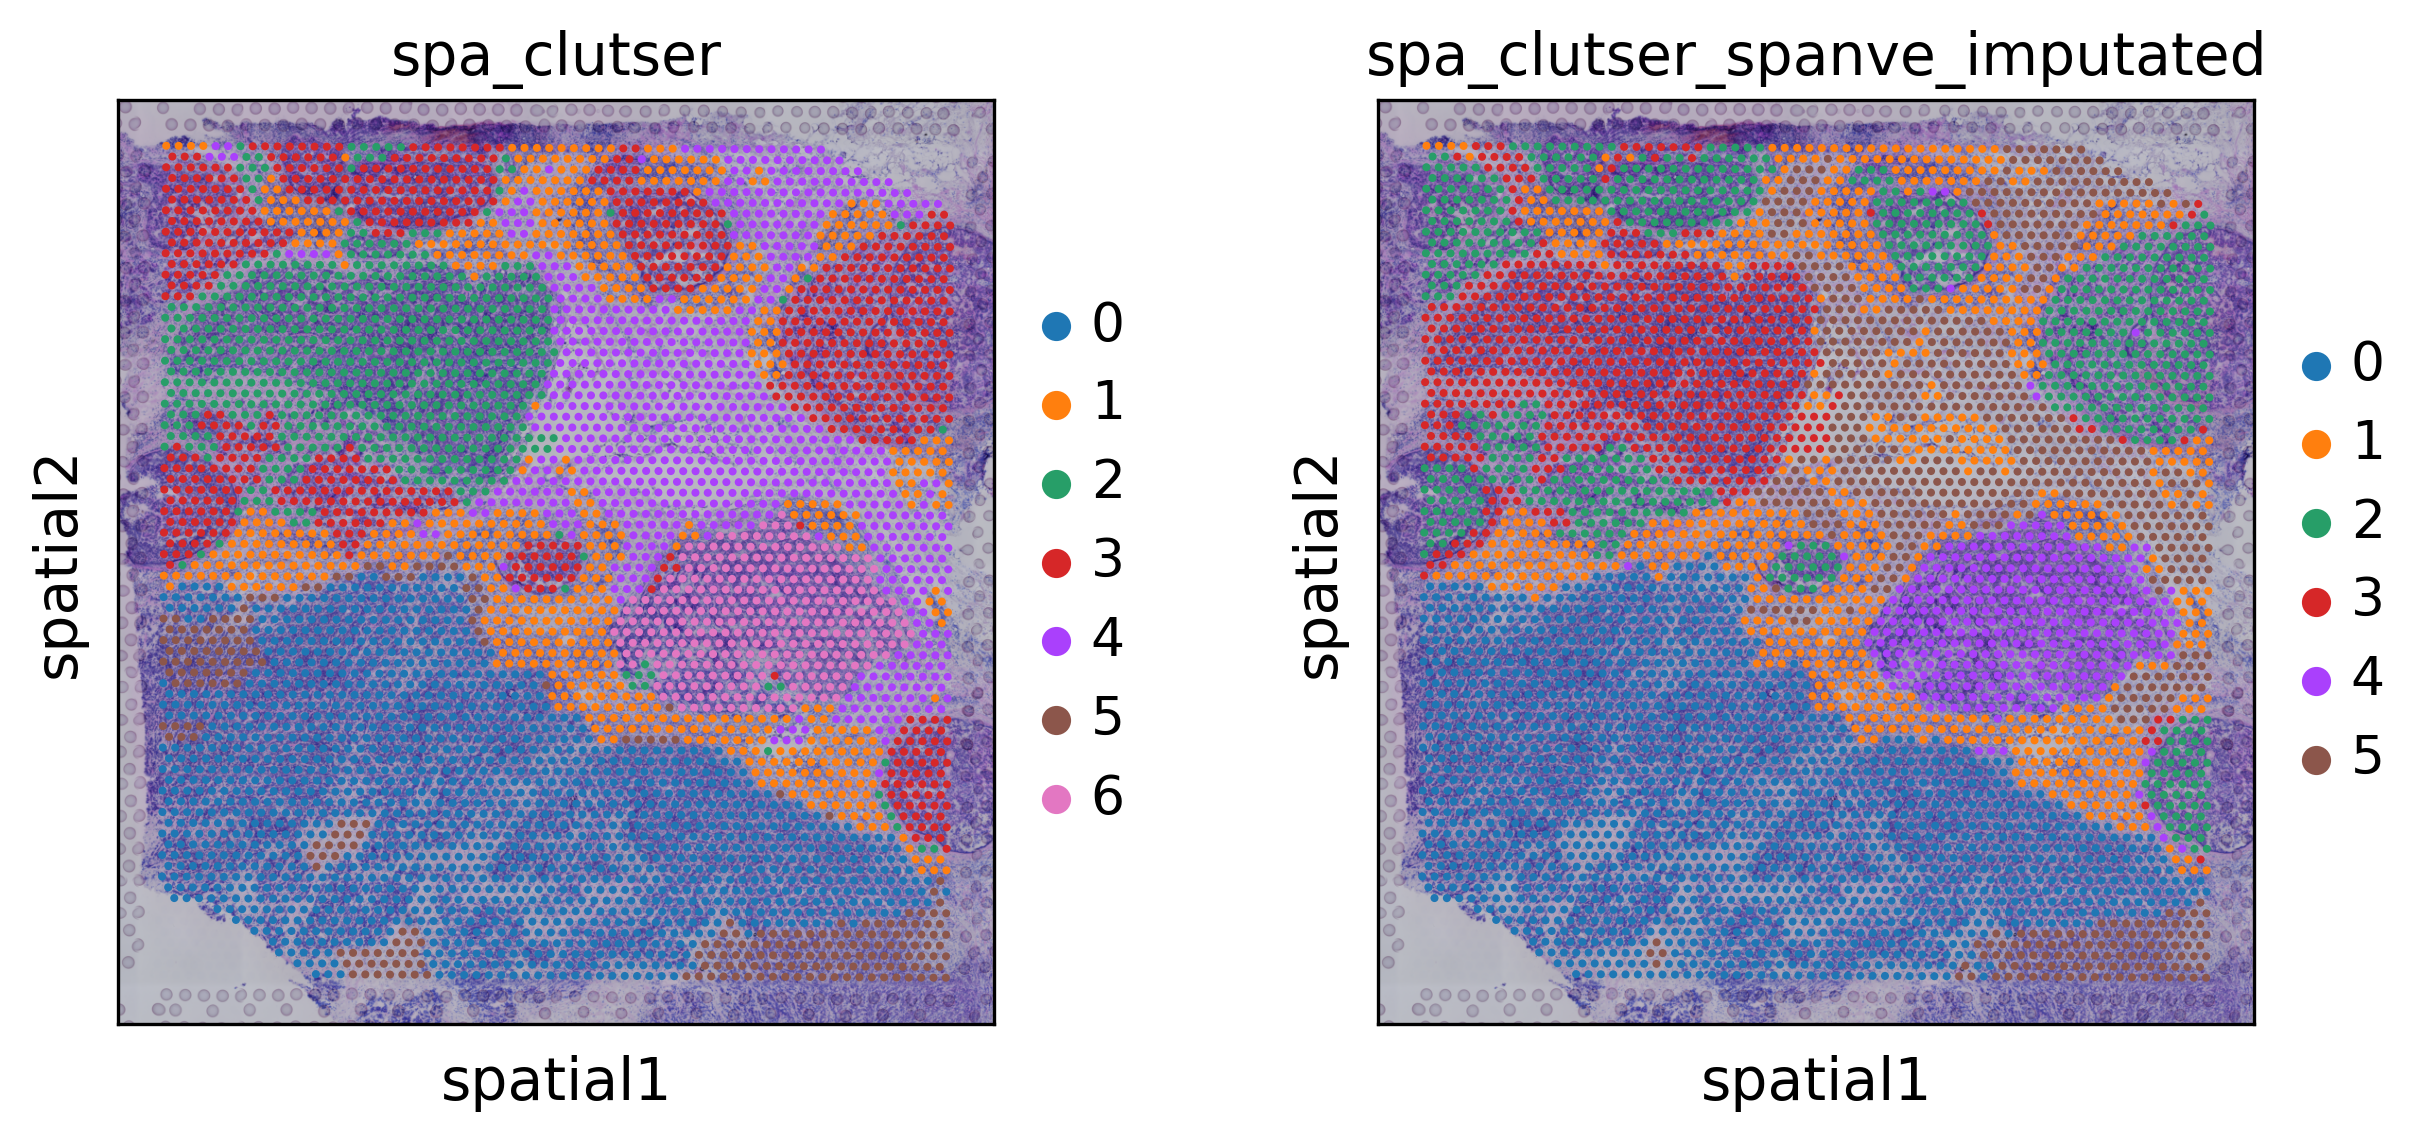

In [37]:
adata.obs['spa_clutser'] = np.array(label, dtype=str)
adata.obs['spa_clutser_spanve_imputated'] = np.array(label_s, dtype=str)

sc.set_figure_params(dpi=150, dpi_save = 300)
sc.pl.spatial(
    adata, color = ['spa_clutser','spa_clutser_spanve_imputated'],
    save = 'spg_BC_cluster.pdf'
)

adata.obs[['spa_clutser','spa_clutser_spanve_imputated']].to_csv('./recode/BreastCancer/spg_clustering.csv')